# Conahap MATH 177 Lab 2

In [1]:
from scipy import *
from numpy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
from numpy.random import *
from scipy.io import loadmat
import scipy.sparse as sp
from scipy.sparse.linalg import eigs,spsolve,gmres,minres,cg
from scipy.sparse.linalg import LinearOperator,spilu
import networkx as nx
from skimage import data as testimages
from skimage.color import rgb2gray
from timeit import default_timer as timer
#import FNC

In [2]:
from pyamg import *

# %run FNC02.py (copy-pasted)

In [3]:
def forwardsub(L,b):
	"""
 	forwardsub(L,b)
	Solve the lower-triangular linear system with matrix L and right-hand side
	vector b.
	"""
	n = len(b)
	x = zeros(n)
	for i in range(n):
		s = L[i,:i] @ x[:i]
		x[i] = ( b[i] - s ) / L[i,i]
	return x

def backsub(U,b):
	"""
	backsub(U,b)
	Solve the upper-triangular linear system with matrix U and right-hand side
	vector b.
	"""
	n = len(b)
	x = zeros(n)
	for i in range(n-1,-1,-1):
		s = U[i,i+1:] @ x[i+1:]
		x[i] = ( b[i] - s ) / U[i,i]
	return x

def lufact(A):
	"""
	lufact(A)
	Compute the LU factorization of square matrix A, returning the factors.
	"""
	n = A.shape[0]
	L = eye(n)      # puts ones on diagonal
	U = copy(A)

	# Gaussian elimination
	for j in range(n-1):
		for i in range(j+1,n):
			L[i,j] = U[i,j] / U[j,j]   # row multiplier
			U[i,j:] = U[i,j:] - L[i,j]*U[j,j:]
	return L,triu(U)
 
#%run FNC08.py
def poweriter(A,numiter):
	"""
	poweriter(A,numiter)
	Perform `numiter` power iterations with the matrix `A`, starting from a random vector,	and return a vector of eigenvalue estimates and the final eigenvector approximation.
	"""
	n = A.shape[0]
	x = randn(n)
	x = x/norm(x,Inf)
	gamma = zeros(numiter)
	for k in range(numiter):
		y = A@x
		m = argmax(abs(y))
		gamma[k] = y[m]/x[m]
		x = y/y[m]

	return gamma,x

def inviter(A,s,numiter):
	"""
	inviter(A,s,numiter)
	Perform `numiter` inverse iterations with the matrix `A` and shift `s`, starting
	from a random vector, and return a vector of eigenvalue estimates and the final
	eigenvector approximation.
	"""
	n = A.shape[0]
	x = randn(n)
	x = x/norm(x,Inf)
	gamma = zeros(numiter)
	PL,U = lu(A - s*eye(n),permute_l=True)
	for k in range(numiter):
		y = solve(U,solve(PL,x))
		m = argmax(abs(y))
		gamma[k] = x[m]/y[m] + s
		x = y/y[m]

	return gamma,x

def arnoldi(A,u,m):
	"""
	arnoldi(A,u,m)
	Perform the Arnoldi iteration for `A` starting with vector `u`, out to the Krylov
	subspace of degree `m`. Return the orthonormal basis (`m`+1 columns) and the upper
	Hessenberg `H` of size `m`+1 by `m`.
	"""
	n = u.size
	Q = zeros([n,m+1])
	H = zeros([m+1,m])
	Q[:,0] = u/norm(u)
	for j in range(m):
		# Find the new direction that extends the Krylov subspace.
		v = A@Q[:,j]
		# Remove the projections onto the previous vectors.
		for i in range(j+1):
			H[i,j] = Q[:,i]@v
			v -= H[i,j]*Q[:,i]
		# Normalize and store the new basis vector.
		H[j+1,j] = norm(v)
		Q[:,j+1] = v/H[j+1,j]

	return Q,H

def arngmres(A,b,m):
	"""
	arngmres(A,b,m)
	Do `m` iterations of GMRES for the linear system `A`*x=`b`. Return the final solution
	estimate x and a vector with the history of residual norms. (This function is for
	demo only, not practical use.)
	"""
	n = len(b)
	Q = zeros([n,m+1])
	Q[:,0] = b/norm(b)
	H = zeros([m+1,m])

	# Initial "solution" is zero.
	residual = hstack([norm(b),zeros(m)])

	for j in range(m):
		# Next step of Arnoldi iteration.
		v = A@Q[:,j]
		for i in range(j+1):
			H[i,j] = Q[:,i]@v
			v -= H[i,j]*Q[:,i]
		H[j+1,j] = norm(v)
		Q[:,j+1] = v/H[j+1,j]

		# Solve the minimum residual problem.
		r = hstack([norm(b), zeros(j+1)])
		z = lstsq(H[:j+2,:j+1],r)[0]
		x = Q[:,:j+1]@z
		residual[j+1] = norm( A@x - b )

	return x,residual

def sprandsym(n,density,**kwargs):
	if "rcond" in kwargs:
		ev = array([ kwargs["rcond"]**(i/(n-1)) for i in range(n) ])
	elif "eigvals" in kwargs:
		ev = kwargs["eigvals"]
	else:
		ev = sqrt(n)*randn(n)

	def randjr(A):
		# Random Jacobi rotation similarity transformation.
		theta = 2*pi*rand()
		c = cos(theta); s = sin(theta)
		idx = [int(k) for k in floor(n*rand(2)) ]
		R = array([[c,s],[-s,c]])
		A[idx,:] = R @ A[idx,:]
		A[:,idx] = A[:,idx] @ R.T
		return A

	targetnz = ceil(min(0.98,density)*n*n)
	A = diags(ev,0,format="lil")
	while A.nnz < targetnz:
		A = randjr(A)
	
	return csc_matrix(A)

In [4]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats


#set_matplotlib_formats("svg","pdf")

%matplotlib inline
# settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# MATH 177 Laboratory
## Inverse and power iteration


Each task is worth 5 points. Label your plots accordingly.

1. (Exercise 8.3.5) Consider a mass-lumped model of an idealized membrane hanging from a square frame (see Exercise 26.3 of the reference for more details). We use cartesian grid of masses, each mass directly interacting with the four neighbors immediately to the north, south, east, and west. If $n$ masses are used in each coordinate direction, we get a sparse matrix $A$ of size $n^2 \times n^2$, which can be done in ``pyamg`` by
<l1><center>  ``A = n**2*poisson((n,n), format = 'csr')``. </center></l1>

    (a) Let $n=10$ and make a ``spy`` plot of $A$. What is the density of $A$? 
    
    (b) The eigenvalues of $A$ area approximately squares of the frequencies of vibration for the membrane. Using ``eigs``, find the dominant $\lambda_1$ for $n=10,15,20,25$.
    
    (c) For each case of $n$ in part (b), apply $100$ steps of ``poweriter`` function. On one graph plot the four convergence curves $\left|\gamma_k - \lambda_1 \right|$ using a semi-log scale. (They will not be smooth curves, because the matrix has many repeated eigenvalues that complicate our convergence analysis.)
    
    (d) For the same values of $n$ in part (b), Using ``eigs``, find the eigenvalue $\lambda_m$ closest to zero.
    
    (e) For each case of $n$ in part (b), apply $50$ steps of ``inviter`` function. On one graph plot the four convergence curves $\left|\gamma_k - \lambda_1 \right|$ using a semi-log scale. 
     
    (f) Let $v$ be the eigenvector (second output) found by ``inviter``. With $n=25$ visualize $v$ in a surface plot (or mesh plot) to see the physical vibration mode associated with this lowest frequence of the membrane.
    
    
2. 
    (a) Modify `inviter` to use a dynamic shift. Change the value of the shift `s` to be the most recent value in `gamma`. Note that the matrix `A - s*eye(n)` must also change with each iteration, and the LU factorization cannot be done just once. (Post the modified `inviter` as a new function in a cell, name it `inviter2`.)
    
    (b) Let `A = magic(99)/99` (`magic(n)` stands for the magic matrix, a square matrix with an odd order and whose sums per row, per column, or per diagonal, is the same). Compute the eigenvalues of `A` using `eigs`. Using an initial shift of $s=100$, apply the dynamic inverse iteration. Determine which eigenvalues was found, and make a table of the `log10` of the erros in the iteration as a function of the iteration number. (They should approximately double, until machine precision is reached, due to quadratic convergence.
    
    (c) Repeat part (b) using an initial shift of your choice.

Notes:

Item 1 (a):

To create a required Poisson matrix, check out `poisson` command from the `pyamg` library, which requires `numpy`. Read more about `pyamg` in https://github.com/pyamg/pyamg

See also https://en.wikipedia.org/wiki/Discrete_Poisson_equation for a quick background on the problem.

### (a) Let  n=10  and make a spy plot of  A . What is the density of  A ?

In [5]:
from pyamg.gallery import poisson

#Define n and matrix A
n = 10
A = n**2*poisson((n,n), format = 'csr')

Text(0.5, 1.0, 'Spy Plot of A')

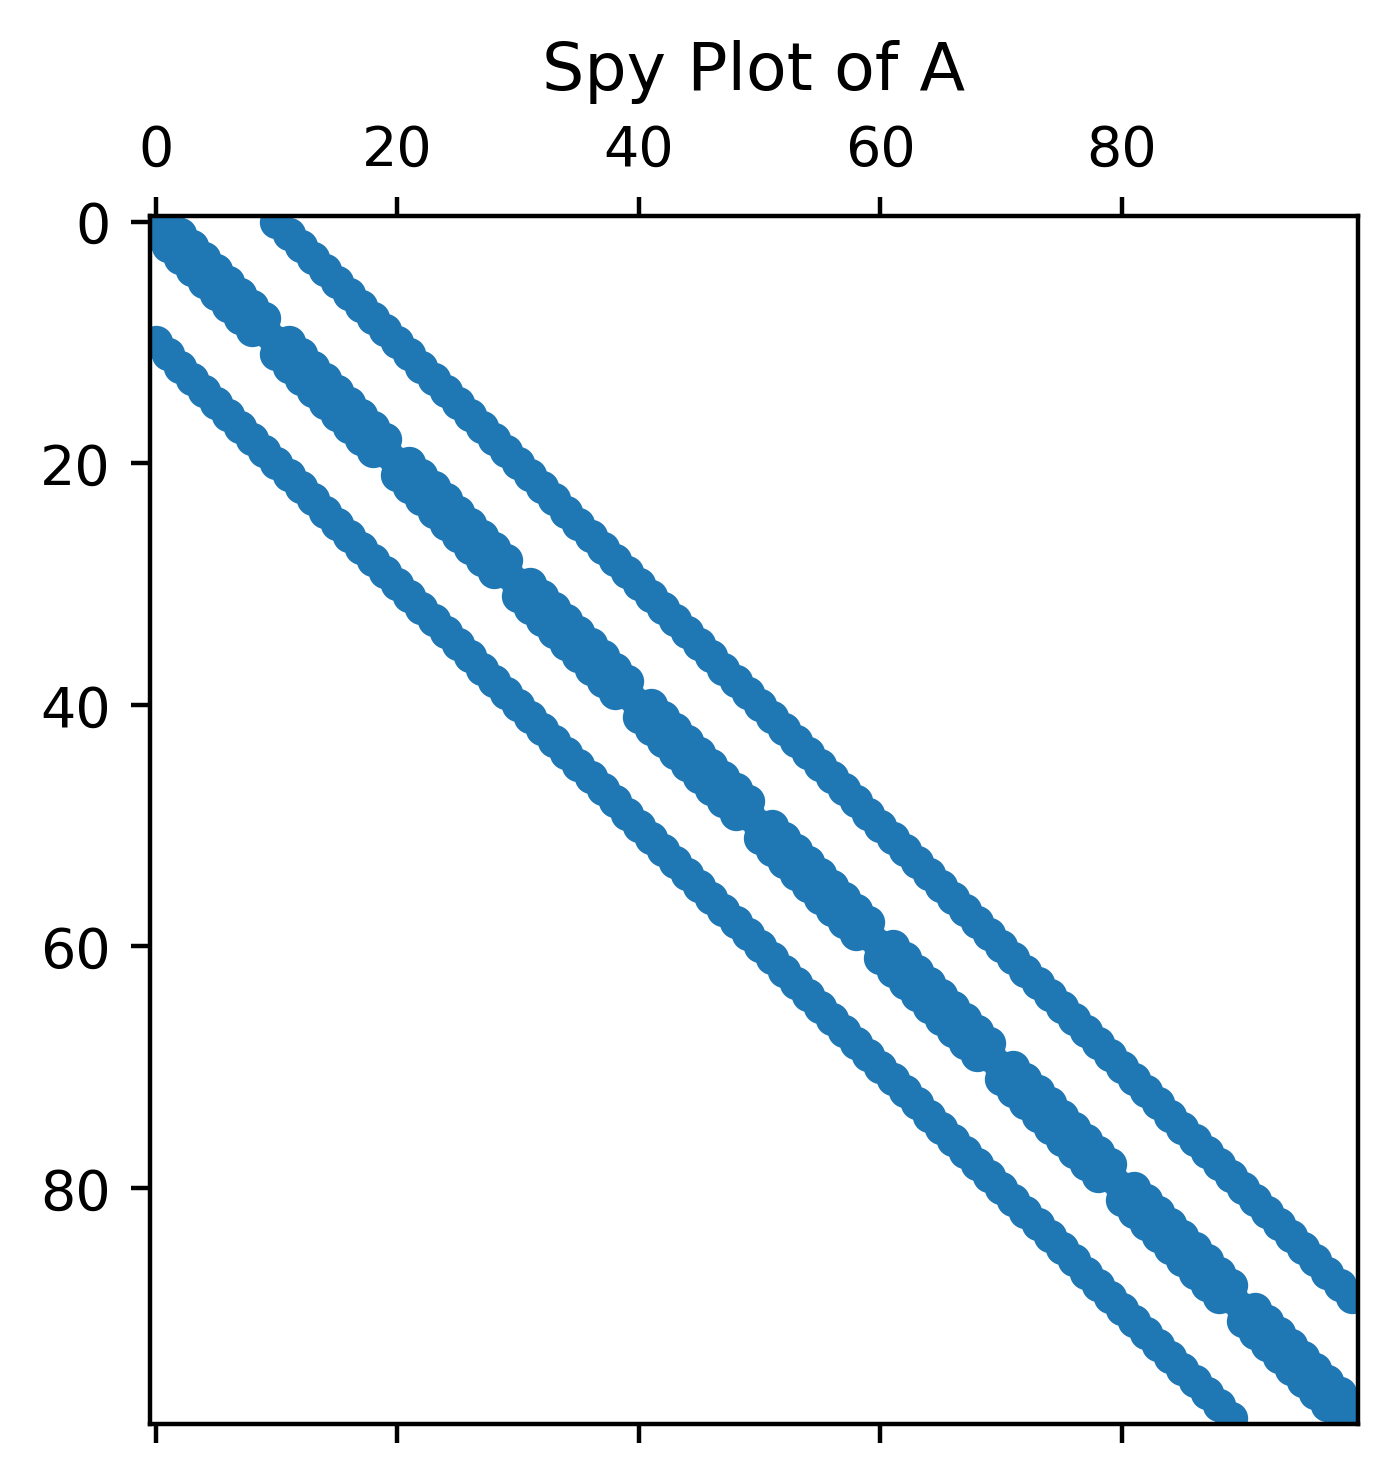

In [6]:
#Create spy plot of A
spy(A, marker = '.')
title("Spy Plot of A")

In [7]:
#Density of A
m, n = A.shape

density = A.nnz / (m*n) #number of nonzeros / total number of entries

print("Density of A: ", density)

Density of A:  0.046


### (b) The eigenvalues of  A  area approximately squares of the frequencies of vibration for the membrane. Using eigs, find the dominant  λ1  for  n=10,15,20,25 .


In [8]:
n = [10, 15, 20, 25]

for i in range(len(n)):
    A2 = n[i]**2*poisson((n[i],n[i]), format = 'csr')
    eigenvalues, V = eigs(A2,  k=5, which = 'LM')
    print("\nFor n = ", n[i], ", the dominant eigenvalues are ", eigenvalues)


For n =  10 , the dominant eigenvalues are  [783.79718945+0.j 736.50141313+0.j 722.87074151+0.j 760.14930129+0.j
 760.14930129+0.j]

For n =  15 , the dominant eigenvalues are  [1782.70675236+0.j 1731.49157926+0.j 1757.09916581+0.j 1757.09916581+0.j
 1715.51470172+0.j]

For n =  20 , the dominant eigenvalues are  [3182.12932196+0.j 3128.91648926+0.j 3155.52290561+0.j 3155.52290561+0.j
 3111.8397553 +0.j]

For n =  25 , the dominant eigenvalues are  [4981.77218525+0.j 4927.35454357+0.j 4954.56336441+0.j 4954.56336441+0.j
 4909.65639598+0.j]


**Therefore, the dominant eigenvalues are:** <br><br>
**for n = 10**, $\lambda_1 = 783.79718945+0$.j,<br> 
**for n = 15**, $\lambda_1 = 1782.70675236+0.j$, <br> 
**for n = 20**, $\lambda_1 = 3182.12932196+0.j$, and  <br>
**for n = 25**, $\lambda_1 = 4981.77218525+0.j$. <br> 

### (c) For each case of  n  in part (b), apply  100  steps of poweriter function. On one graph plot the four convergence curves $|γk−λ1|$  using a semi-log scale. (They will not be smooth curves, because the matrix has many repeated eigenvalues that complicate our convergence analysis.)


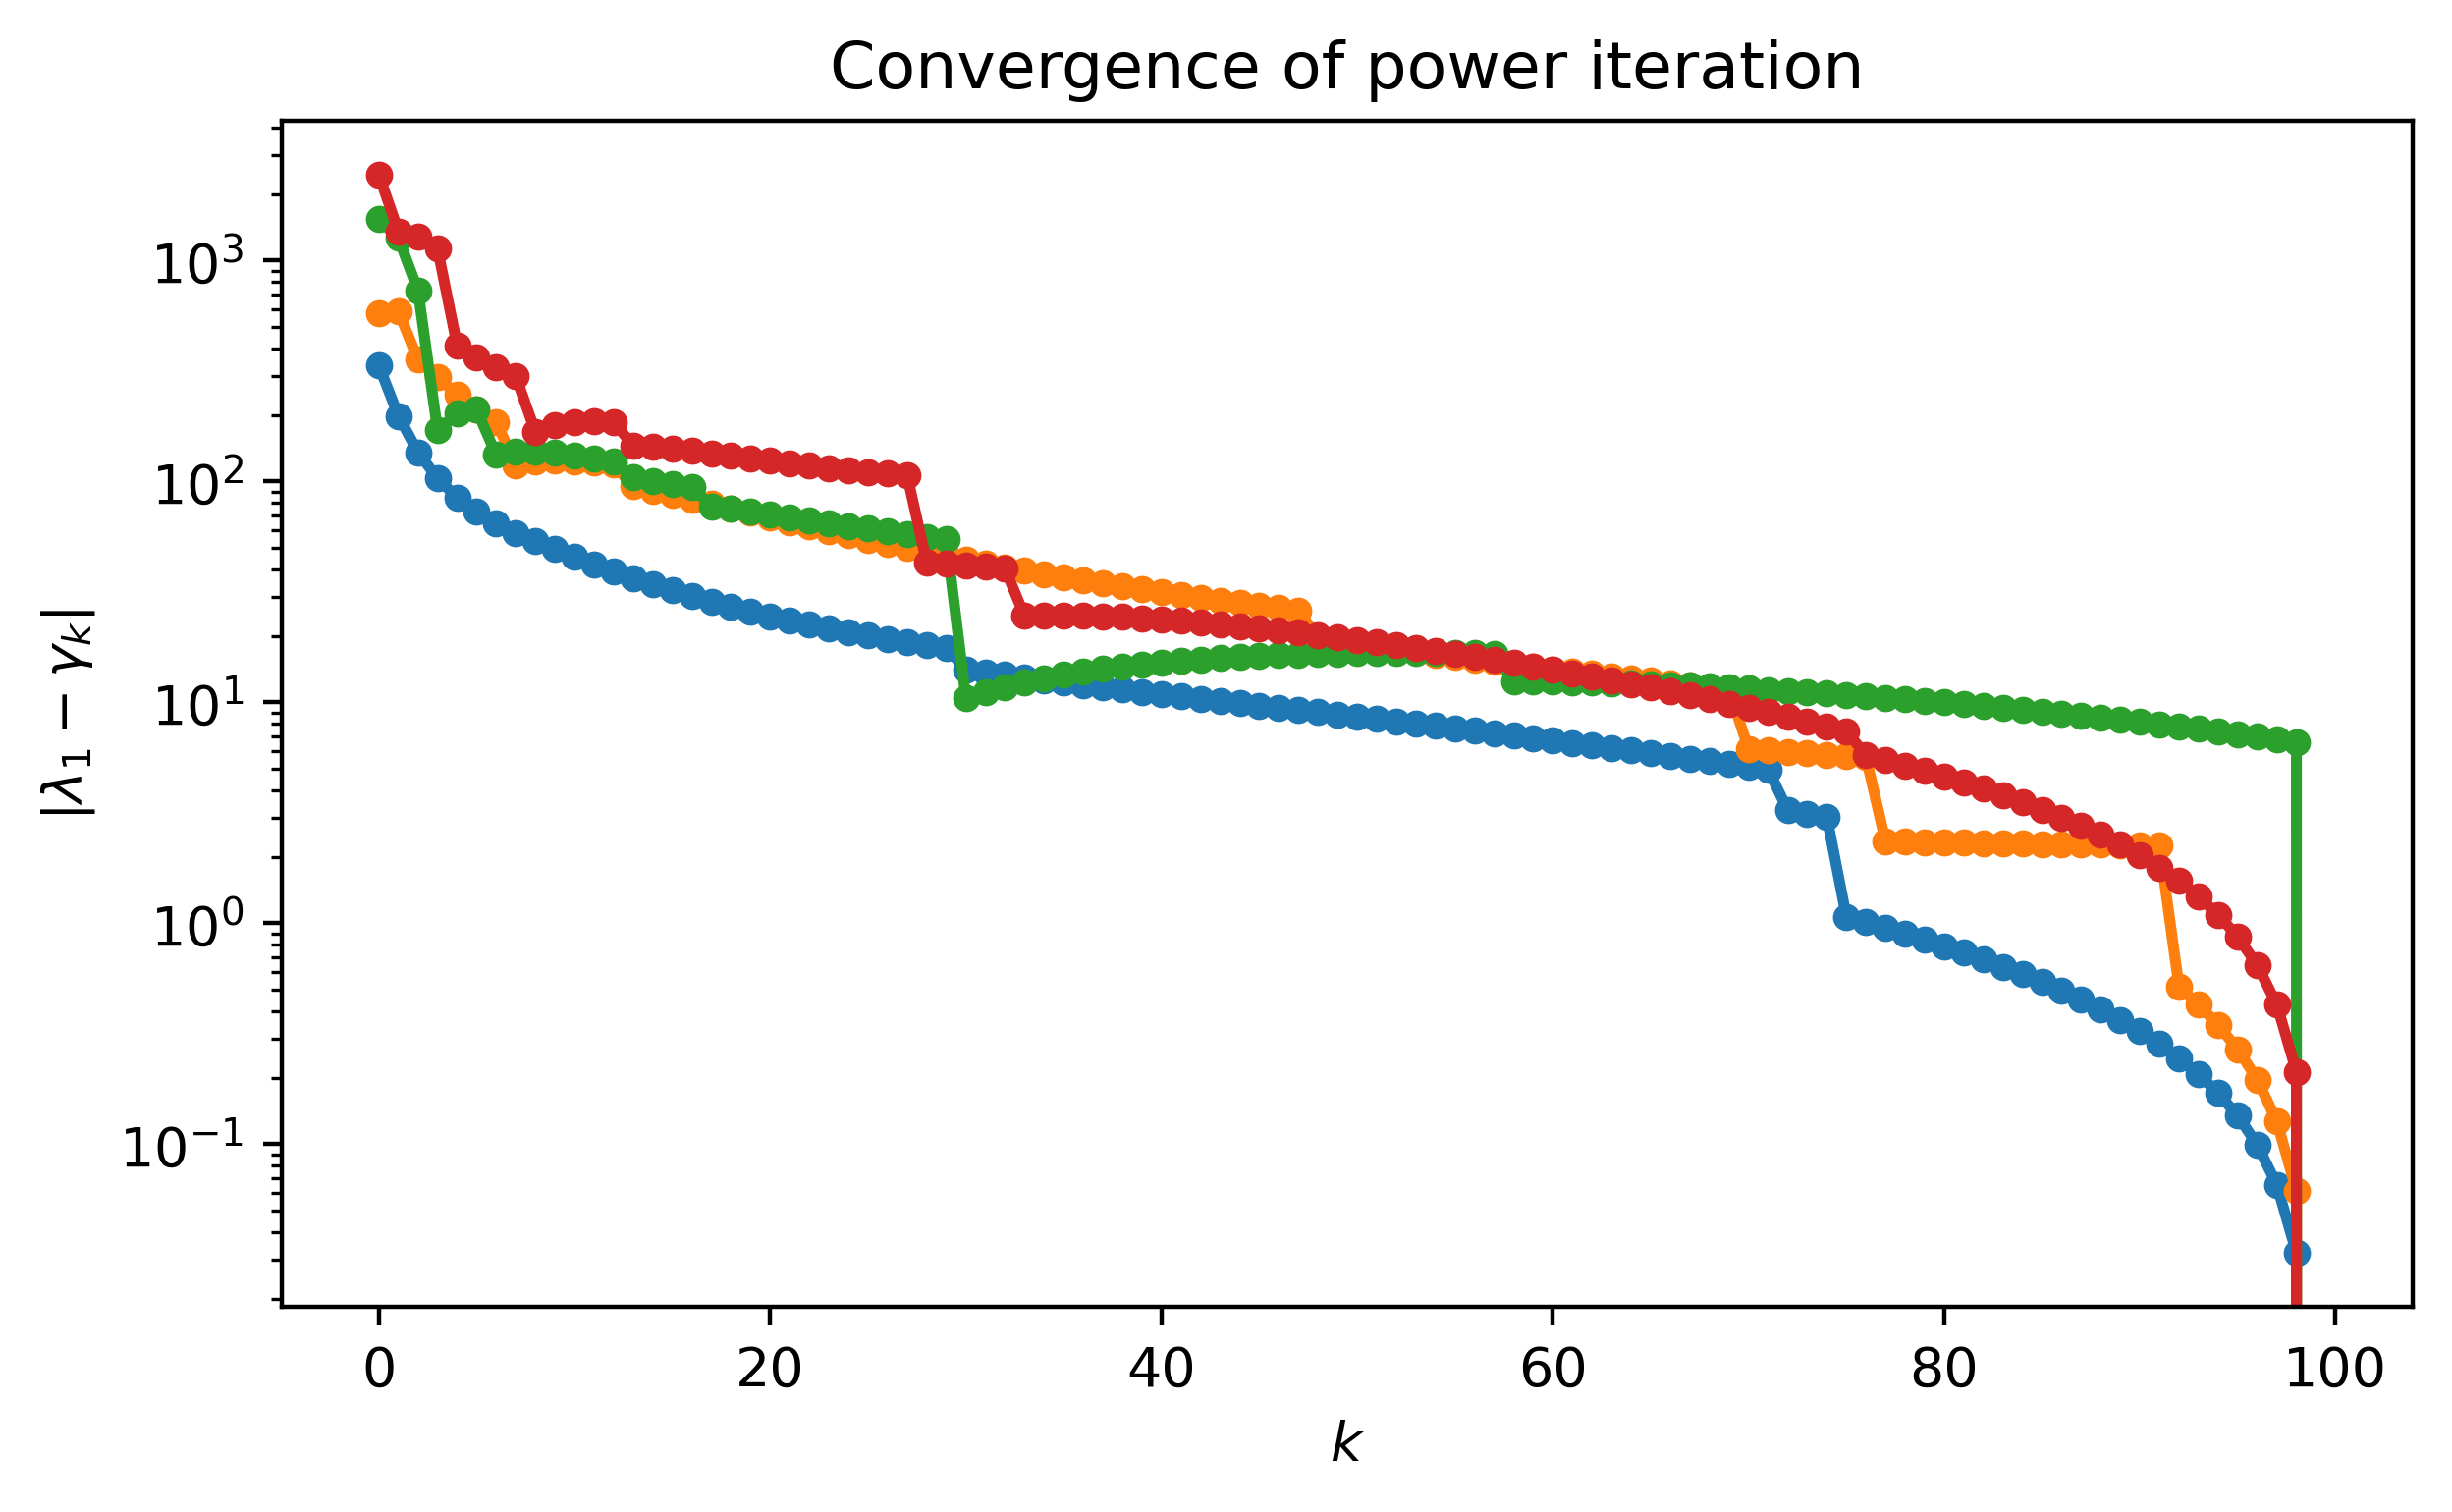

In [9]:
for i in range(len(n)):
    A2 = n[i]**2*poisson((n[i],n[i]), format = 'csr')
    gamma, x = poweriter(A2,100)
    eigenvalue = gamma[-1]
    
    error = eigenvalue - gamma 

    semilogy(arange(100), abs(error),"-o")

xlabel("$k$"); ylabel("$|\lambda_1 - \gamma_k|$")
title("Convergence of power iteration"); show()

### (d) For the same values of  n  in part (b), Using eigs, find the eigenvalue  λm  closest to zero.

In [10]:
n = [10, 15, 20, 25]

for i in range(len(n)):
    A2 = n[i]**2*poisson((n[i],n[i]), format = 'csr')
    eigenvalues, V = eigs(A,k=5,sigma=0)
    print("\nFor n = ", n[i], ", the eigenvalues closest to zero are ", eigenvalues)


For n =  10 , the eigenvalues closest to zero are  [16.20281055+0.j 63.49858687+0.j 39.85069871+0.j 39.85069871+0.j
 77.12925849+0.j]

For n =  15 , the eigenvalues closest to zero are  [16.20281055+0.j 63.49858687+0.j 39.85069871+0.j 39.85069871+0.j
 77.12925849+0.j]

For n =  20 , the eigenvalues closest to zero are  [16.20281055+0.j 63.49858687+0.j 39.85069871+0.j 39.85069871+0.j
 77.12925849+0.j]

For n =  25 , the eigenvalues closest to zero are  [16.20281055+0.j 63.49858687+0.j 39.85069871+0.j 39.85069871+0.j
 77.12925849+0.j]


**Therefore, the eigenvalues closest to zero <br><br>
for n = 10, $\lambda_m = 16.20281055+0.j$; <br> 
for n = 15, $\lambda_m = 16.20281055+0.j$; <br>
for n = 20, $\lambda_m = 16.20281055+0.j$; and<br>
for n = 25, $\lambda_m = 16.20281055+0.j$.** <br> 

### (e) For each case of  n  in part (b), apply  50  steps of inviter function. On one graph plot the four convergence curves  |γk−λ1|  using a semi-log scale.

Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.11e-14, 4.94e+00
  Residual reduction ||r_k||_M/||r_0||_M = 2.24e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.63e-13, 6.92e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.36e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.34e-14, 6.14e+00
  Residual reduction ||r_k||_M/||r_0||_M = 2.19e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.60e-13, 7.38e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.17e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
 

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.55e-13, 6.88e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.25e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.26e-14, 1.02e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.22e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.40e-13, 7.76e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.10e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.09e-14, 1.01e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.08e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
 

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.14e-14, 9.79e+00
  Residual reduction ||r_k||_M/||r_0||_M = 2.18e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.72e-13, 6.89e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.50e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.06e-14, 1.02e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.03e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.56e-13, 6.85e+01
  Residual reduction ||r_k||_M/||r_0||_M = 2.28e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
 

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

  Residuals ||r_k||_M, ||r_0||_M = 6.04e-14, 1.79e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.37e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 3.87e-13, 1.51e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.56e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 6.10e-14, 1.80e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.40e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 3.98e-13, 1.57e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.53e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.49e-14, 1.77e+01
  Resi

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

  Residuals ||r_k||_M, ||r_0||_M = 4.51e-13, 1.47e+02
  Residual reduction ||r_k||_M/||r_0||_M = 3.06e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.87e-14, 1.78e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.30e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.08e-13, 1.52e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.69e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.74e-14, 1.78e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.23e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 3.84e-13, 1.53e+02
  Resi

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

  Residuals ||r_k||_M, ||r_0||_M = 5.86e-14, 1.78e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.30e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.13e-13, 1.54e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.68e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.89e-14, 1.78e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.31e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.21e-13, 1.42e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.96e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.88e-14, 1.79e+01
  Resi

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

  Residuals ||r_k||_M, ||r_0||_M = 4.05e-13, 1.49e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.72e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.88e-14, 1.77e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.31e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.09e-13, 1.49e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.75e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 6.07e-14, 1.77e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.44e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.25e-13, 1.52e+02
  Resi

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:13

    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.58e-14, 1.79e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.11e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.40e-13, 1.46e+02
  Residual reduction ||r_k||_M/||r_0||_M = 3.01e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 5.97e-14, 1.79e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.33e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 3.90e-13, 1.43e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.73e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 2.97e-1

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')


  Residuals ||r_k||_M, ||r_0||_M = 7.35e-13, 2.52e+02
  Residual reduction ||r_k||_M/||r_0||_M = 2.91e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 8.93e-14, 2.67e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.34e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 7.68e-13, 2.47e+02
  Residual reduction ||r_k||_M/||r_0||_M = 3.11e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 9.00e-14, 2.72e+01
  Residual reduction ||r_k||_M/||r_0||_M = 3.31e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 8.32e-13, 2.73e+02
  Resi

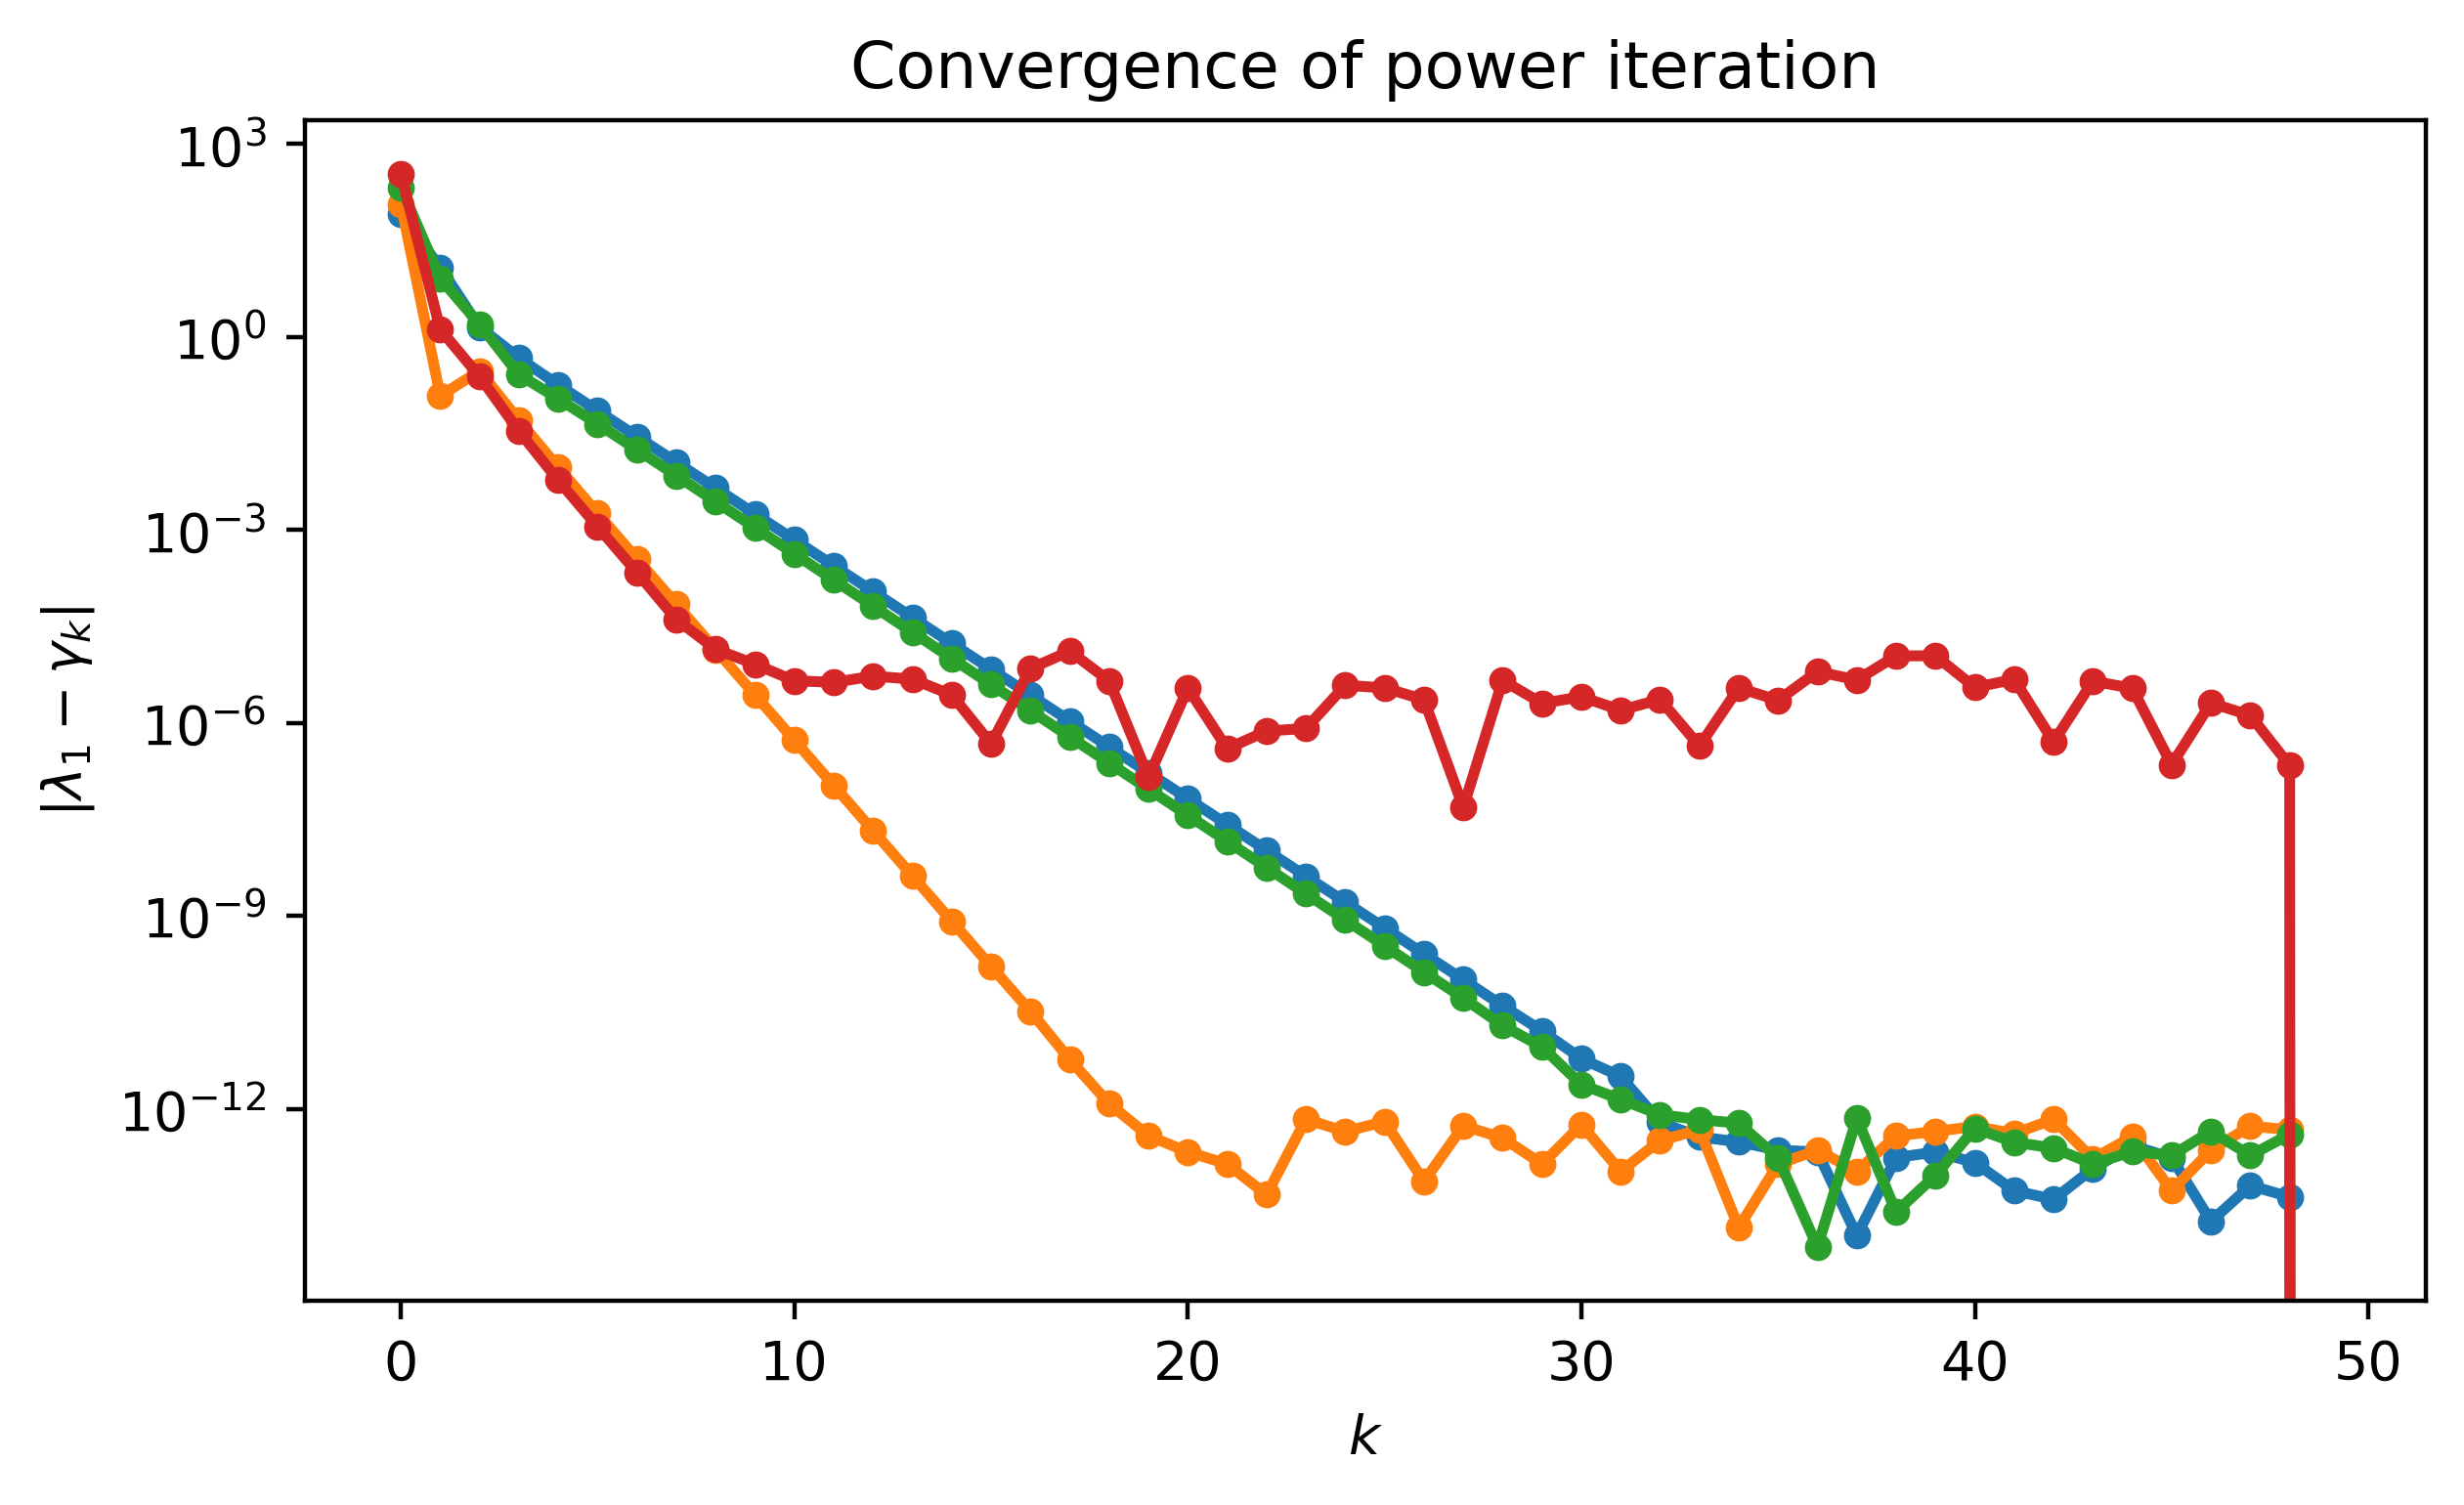

In [11]:
for i in range(len(n)):
    A2 = n[i]**2*poisson((n[i],n[i]), format = 'csr')
    gamma, x = inviter(A2,0.7,50)
    eigenvalue = gamma[-1]
    
    error = eigenvalue - gamma 
    
    semilogy(arange(50), abs(error),"-o")

xlabel("$k$"); ylabel("$|\lambda_1 - \gamma_k|$")
title("Convergence of power iteration")
show()

### (f) Let $v$ be the eigenvector (second output) found by ``inviter``. With $n=25$ visualize $v$ in a surface plot (or mesh plot) to see the physical vibration mode associated with this lowest frequence of the membrane.

C:\Users\aldwi\AppData\Local\Temp\ipykernel_2416\2410639623.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = gca(projection="3d")


AttributeError: 'int' object has no attribute 'ndim'

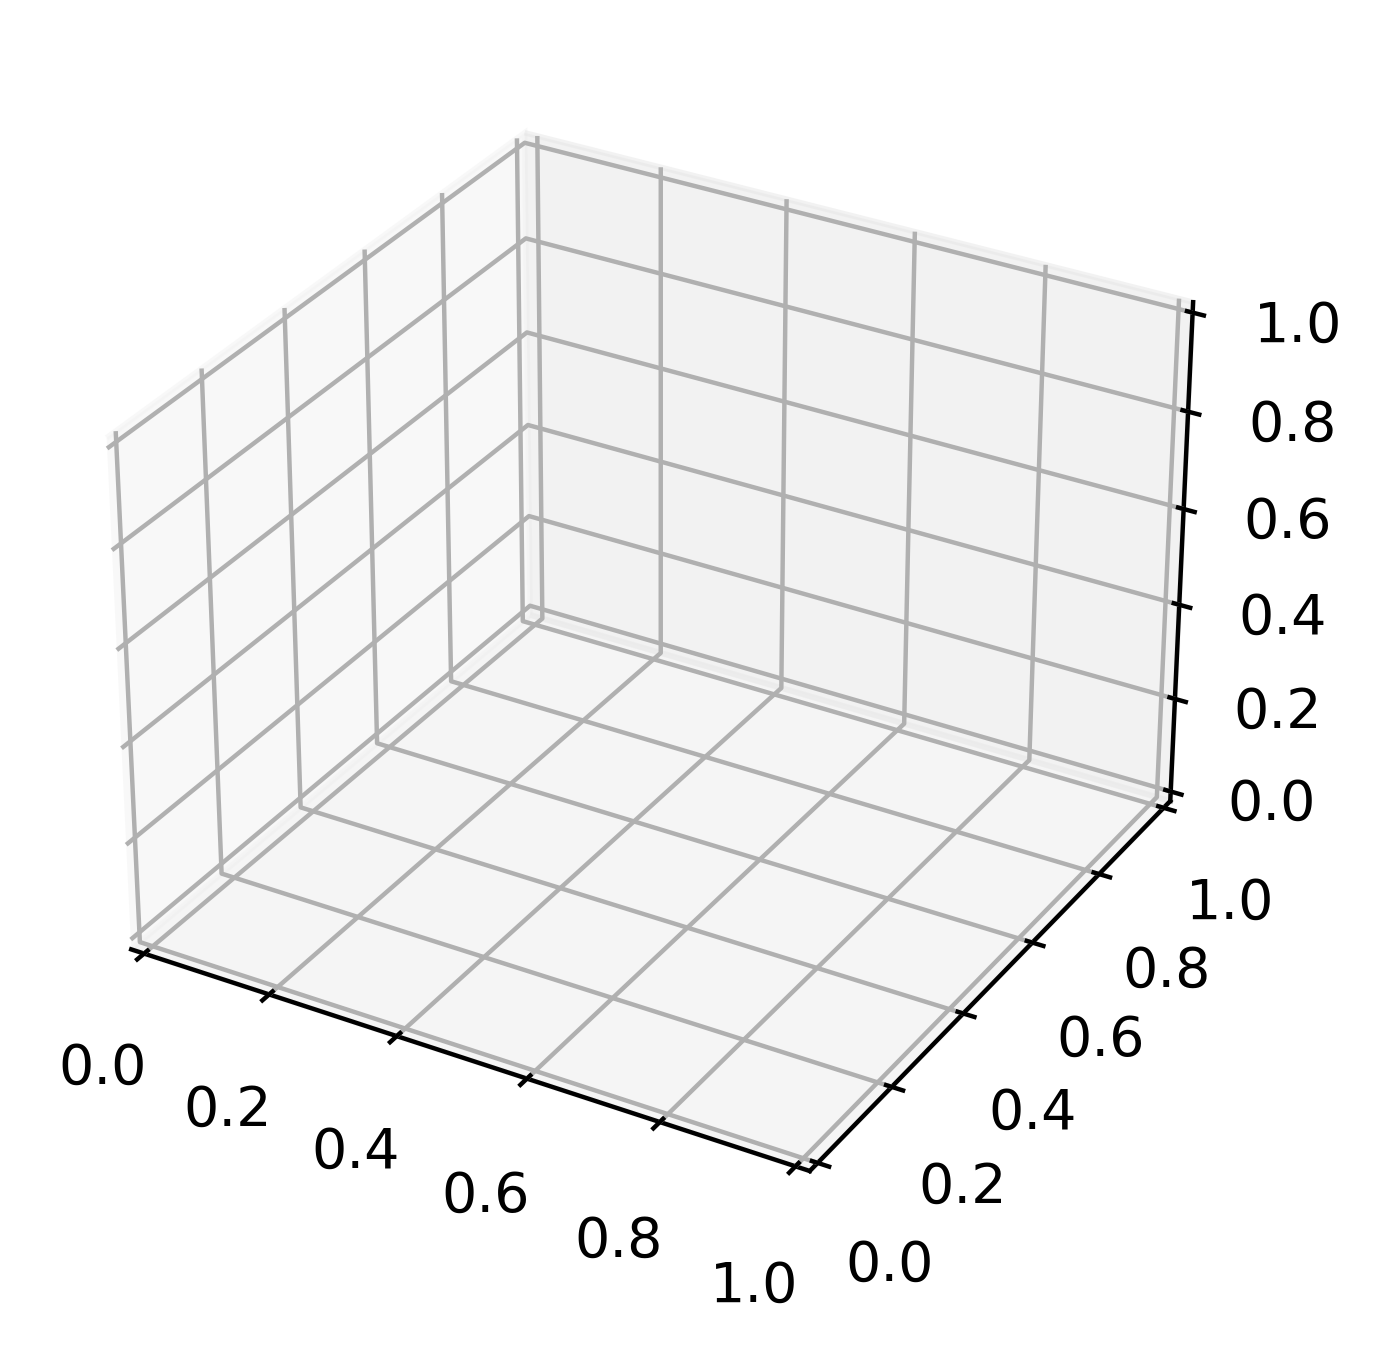

In [12]:
v = x
n=25
ax = gca(projection="3d")
ax.plot_surface(v,n,n) #There is an error because the function plot_surface() need three variables, we only have 1--- the v

### Item 2 (b)

### A `magic` function is provided in a separate `.py` file. Make sure you run it as

### %run magic.py    

In [13]:
import numpy as np

def magic(n):
    n = int(n)
    if n < 3:
        raise ValueError("Size must be at least 3")
    if n % 2 == 1:
        p = np.arange(1, n+1)
        return n*np.mod(p[:, None] + p - (n+3)//2, n) + np.mod(p[:, None] + 2*p-2, n) + 1
    elif n % 4 == 0:
        J = np.mod(np.arange(1, n+1), 4) // 2
        K = J[:, None] == J
        M = np.arange(1, n*n+1, n)[:, None] + np.arange(n)
        M[K] = n*n + 1 - M[K]
    else:
        p = n//2
        M = magic(p)
        M = np.block([[M, M+2*p*p], [M+3*p*p, M+p*p]])
        i = np.arange(p)
        k = (n-2)//4
        j = np.concatenate((np.arange(k), np.arange(n-k+1, n)))
        M[np.ix_(np.concatenate((i, i+p)), j)] = M[np.ix_(np.concatenate((i+p, i)), j)]
        M[np.ix_([k, k+p], [0, k])] = M[np.ix_([k+p, k], [0, k])]
    return M 

### 2.(a) Modify `inviter` to use a dynamic shift. Change the value of the shift `s` to be the most recent value in `gamma`. Note that the matrix `A - s*eye(n)` must also change with each iteration, and the LU factorization cannot be done just once. (Post the modified `inviter` as a new function in a cell, name it `inviter2`.)

In [14]:
def inviter2(A,s,numiter):
    """
    inviter2(A,s,numiter)
    Perform `numiter` inverse iterations with the matrix `A` and shift `s`, starting
    from a random vector, and return a vector of eigenvalue estimates and the final
    eigenvector approximation.
    """
    n = A.shape[0]
    x = randn(n)
    x = x/norm(x,Inf)
    gamma = zeros(numiter)
    for k in range(numiter):
        PL,U = lu(A - s*eye(n),permute_l=True)
        y = solve(U,solve(PL,x))
        m = argmax(abs(y))
        gamma[k] = x[m]/y[m] + s
        x = y/y[m]

        s = gamma[k]
    return gamma,x

### (b) Let `A = magic(99)/99` (`magic(n)` stands for the magic matrix, a square matrix with an odd order and whose sums per row, per column, or per diagonal, is the same). Compute the eigenvalues of `A` using `eigs`. Using an initial shift of $s=100$, apply the dynamic inverse iteration. Determine which eigenvalues was found, and make a table of the `log10` of the erros in the iteration as a function of the iteration number. (They should approximately double, until machine precision is reached, due to quadratic convergence.

In [15]:
#Magic matrix
A = magic(99)/99
A

array([[50.02020202, 51.04040404, 52.06060606, ..., 47.95959596,
        48.97979798, 50.        ],
       [51.03030303, 52.05050505, 53.07070707, ..., 48.96969697,
        49.98989899, 50.01010101],
       [52.04040404, 53.06060606, 54.08080808, ..., 49.97979798,
        51.        , 51.02020202],
       ...,
       [47.98989899, 48.01010101, 49.03030303, ..., 44.92929293,
        45.94949495, 46.96969697],
       [49.        , 49.02020202, 50.04040404, ..., 45.93939394,
        46.95959596, 47.97979798],
       [49.01010101, 50.03030303, 51.05050505, ..., 46.94949495,
        47.96969697, 48.98989899]])

In [16]:
#Compute the eigenvalues of A using eigs
eigenvalues,eigenvectors = eigs(A)
eigenvalues

array([ 4901.        +0.j,  1560.13942739+0.j, -1560.13942739+0.j,
         780.46264356+0.j,  -780.46264356+0.j,  -520.74542848+0.j])

In [17]:
#Using an initial shift of  𝑠=100 , apply the dynamic inverse iteration
gamma, x = inviter2(A,100,10) 

#Determine which eigenvalues was found
gamma

Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.73e-13, 2.04e+01
  Residual reduction ||r_k||_M/||r_0||_M = 8.47e-15
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 8.21e-13, nan
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 4.76e-14, nan
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = nan, 1.30e+02
  Residual reduction ||r_k||_M/||r_0||_M = nan
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = nan, nan
Implicit co

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\blackbox.py:318: RuntimeWarning: invalid value encountered in sqrt
  nr0 = np.sqrt(np.inner(np.conjugate(M * r0), r0))
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\blackbox.py:318: RuntimeWarning: invalid value encountered in sqrt
  nr0 = np.sqrt(np.inner(np.conjugate(M * r0), r0))
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter 

array([96.34957741, 96.45152347, 96.36289439, 96.36398388, 96.36398411,
       98.212321  , 91.32731992, 91.74869808, 91.56076729, 91.55800803])

In [18]:
#Computing for errors
eigval = gamma[-1] #Last eigenvalue is the final estimate
err = eigval - gamma
err

array([-4.79156938e+00, -4.89351544e+00, -4.80488636e+00, -4.80597585e+00,
       -4.80597608e+00, -6.65431297e+00,  2.30688104e-01, -1.90690055e-01,
       -2.75926332e-03,  0.00000000e+00])

In [42]:
math.log10(abs(err))

TypeError: only size-1 arrays can be converted to Python scalars

### (c) Repeat part (b) using an initial shift of your choice.

In [35]:
#shift=80
gamma2, x2 = inviter2(A,50,10) 

#Print eigenvalues
gamma2

Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = nan, 2.16e+01
  Residual reduction ||r_k||_M/||r_0||_M = nan
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = nan, 1.27e+02
  Residual reduction ||r_k||_M/||r_0||_M = nan
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.16e-14, 2.75e+01
  Residual reduction ||r_k||_M/||r_0||_M = 4.21e-16
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Hermitian matrix
    maxiter = 400
    iteration 1.0
  Residuals ||r_k||_M, ||r_0||_M = 1.12e-11, 2.77e+02
  Residual reduction ||r_k||_M/||r_0||_M = 4.06e-14
Implicit conversion of A to CSR in pyamg.blackbox.make_csr
  Detected a non-Herm

C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\blackbox.py:319: RuntimeWarning: invalid value encountered in sqrt
  nrk = np.sqrt(np.inner(np.conjugate(M * rk), rk))
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\blackbox.py:319: RuntimeWarning: invalid value encountered in sqrt
  nrk = np.sqrt(np.inner(np.conjugate(M * rk), rk))
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter to maximum allowed, n.
  warn('Setting maxiter to maximum allowed, n.')
C:\Users\aldwi\anaconda3\lib\site-packages\pyamg\krylov\_gmres_householder.py:138: UserWarning: Setting maxiter 

array([50.05266396, 50.0118675 , 50.00900768, 50.00901971, 50.00901971,
       50.01973451, 49.97284421, 49.78061766, 49.80962632, 49.8075651 ])

In [36]:
#Computing for errors
eigval = gamma2[-1] #Last eigenvalue is the final estimate
err = eigval - gamma2
err

array([-0.24509885, -0.20430239, -0.20144257, -0.20145461, -0.20145461,
       -0.21216941, -0.16527911,  0.02694744, -0.00206122,  0.        ])

In [41]:
math.log10(abs(err))

TypeError: only size-1 arrays can be converted to Python scalars